## 어텐션 매커니즘을 코딩하기
이 notebook에서 사용하는 package를 미리 import 하자

In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))

torch version: 2.5.1


이 노트북에서는 LLM의 핵심인 어텐션 매커니즘을 다룬다
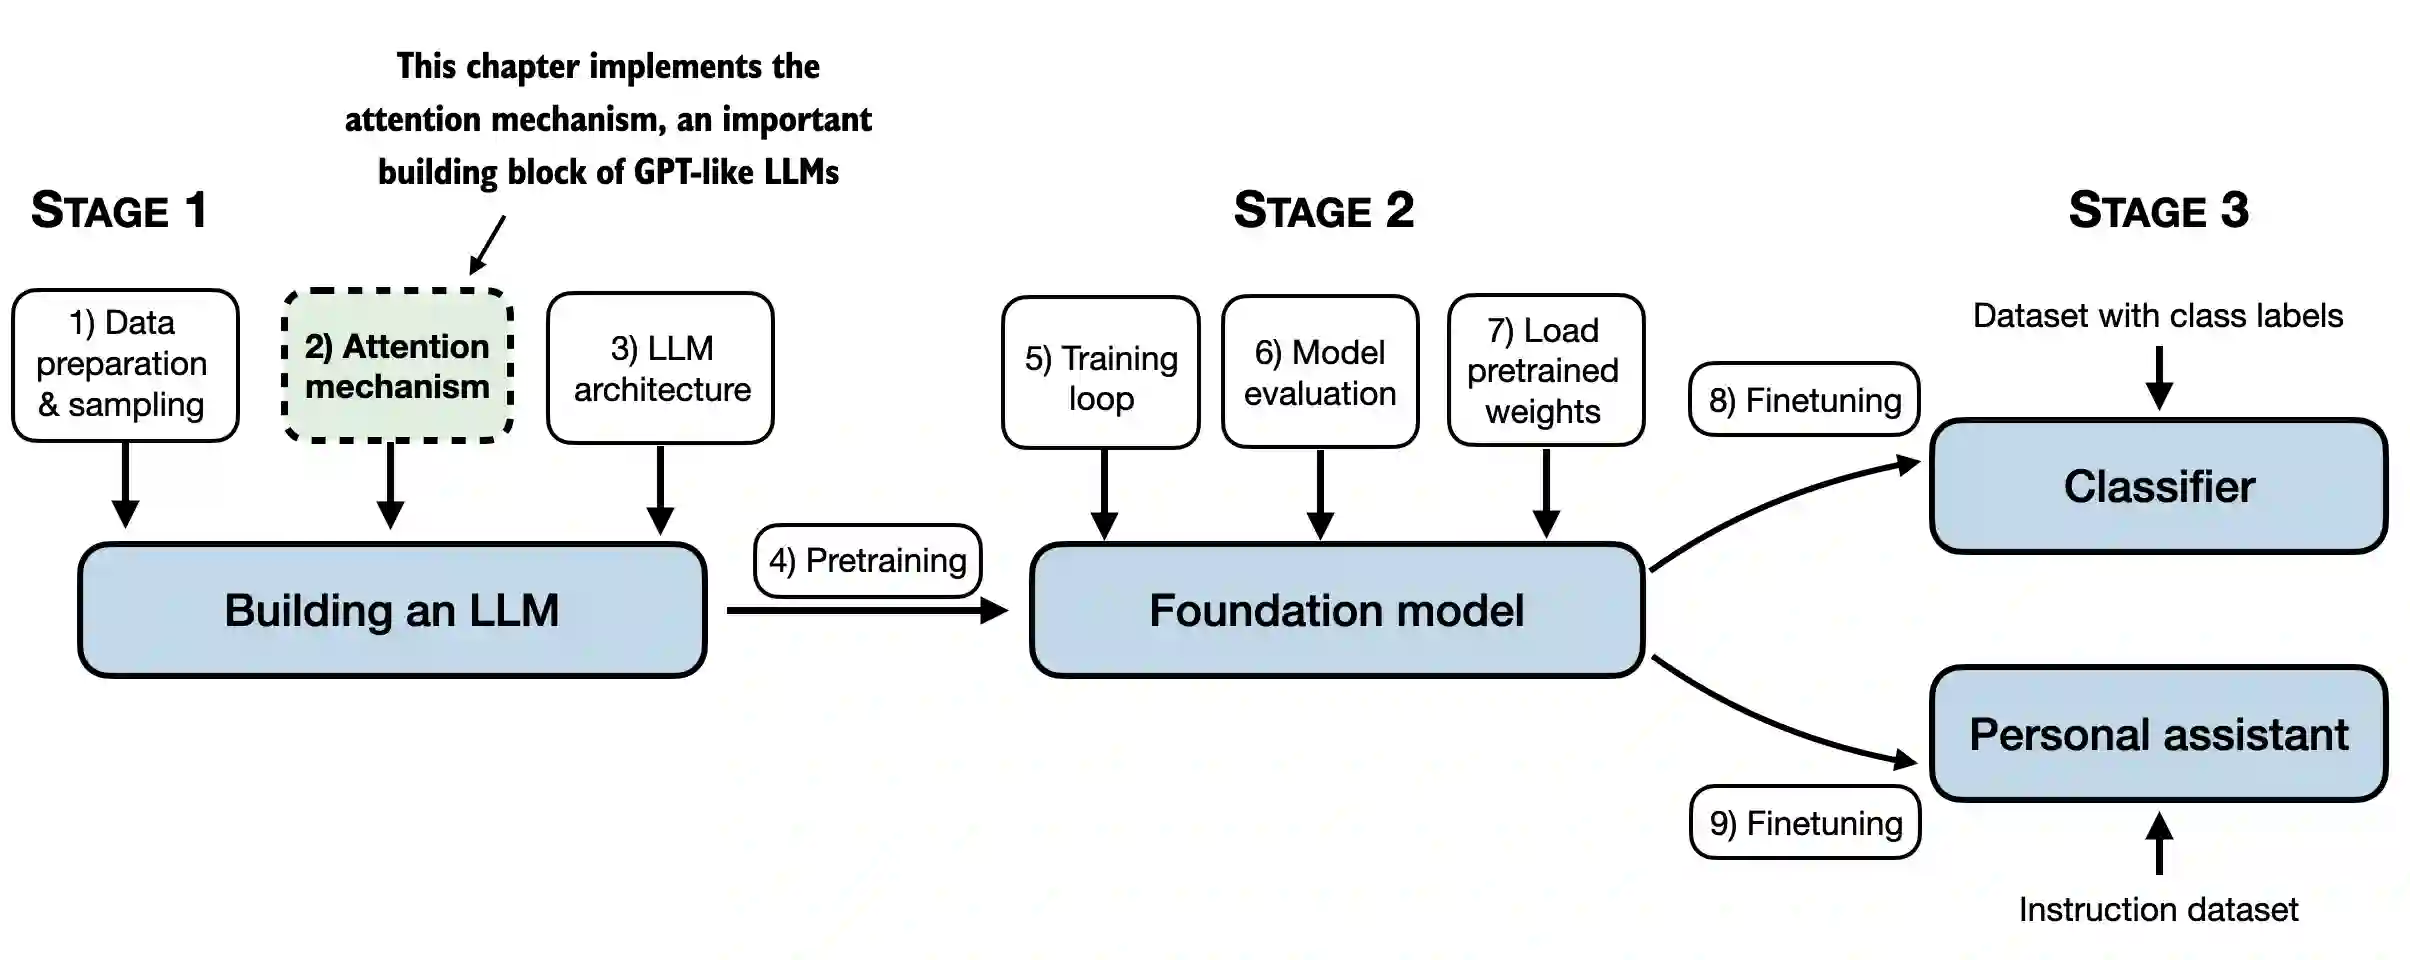

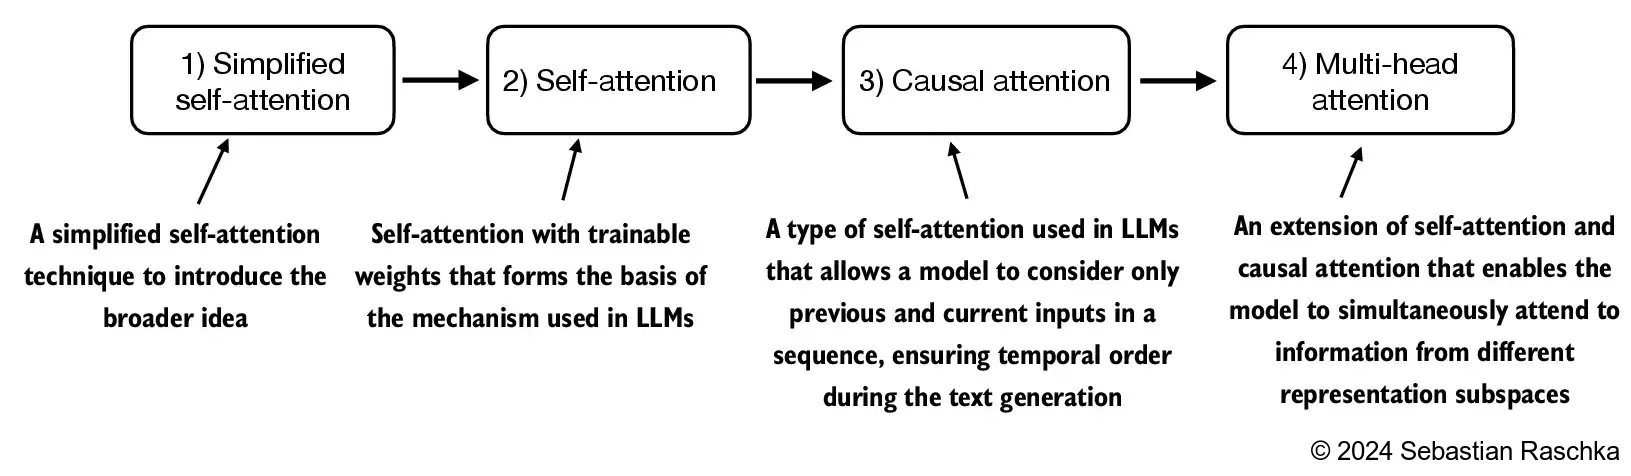
1. 초반에는 단순한 숫자를 사용해서 간단한 self-attention을 코딩
2. 이제는 LLM이 사용하기 위해서 학습 가능한 가중치를 사용한 self attention을 코딩
3. 실제 LLM이 사용하는 방식인 미래의 토큰을 보지 않게 하는 방식, causal attention 방식을 코딩
4. 이 causal attention을 병렬적으로 수행하고 서로 다른 context를 학습할 수 있는 multi head 어텐션 방식을 코딩

### 긴 문장을 LLM이 사용할 수 있게 모델링 할때 발생하는 문제

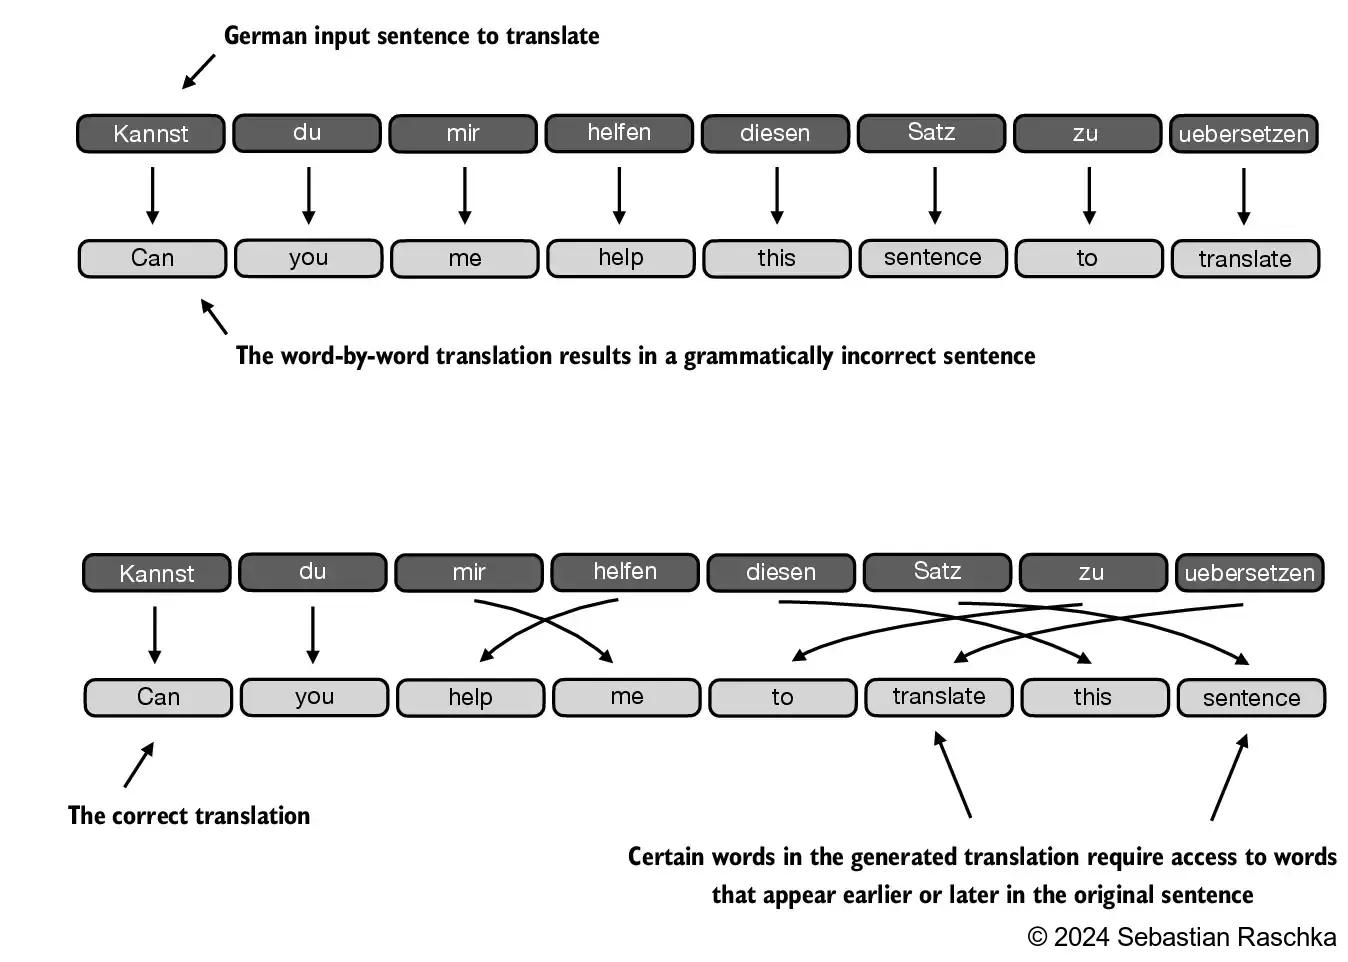
각 언어간 문법적, 어휘적 구조 차이때문에 문장에 있는 단어를 일대일 대응로 직접 번역할 수 없다.
* `i am a boy` 라는 문장을 단어별로 번역하면 `나는 이다 남자` 라고 된다.


트랜스포머 모델 이전에는 기계번역 작업에 encoder-decoder RNN을 주로 사용했다.
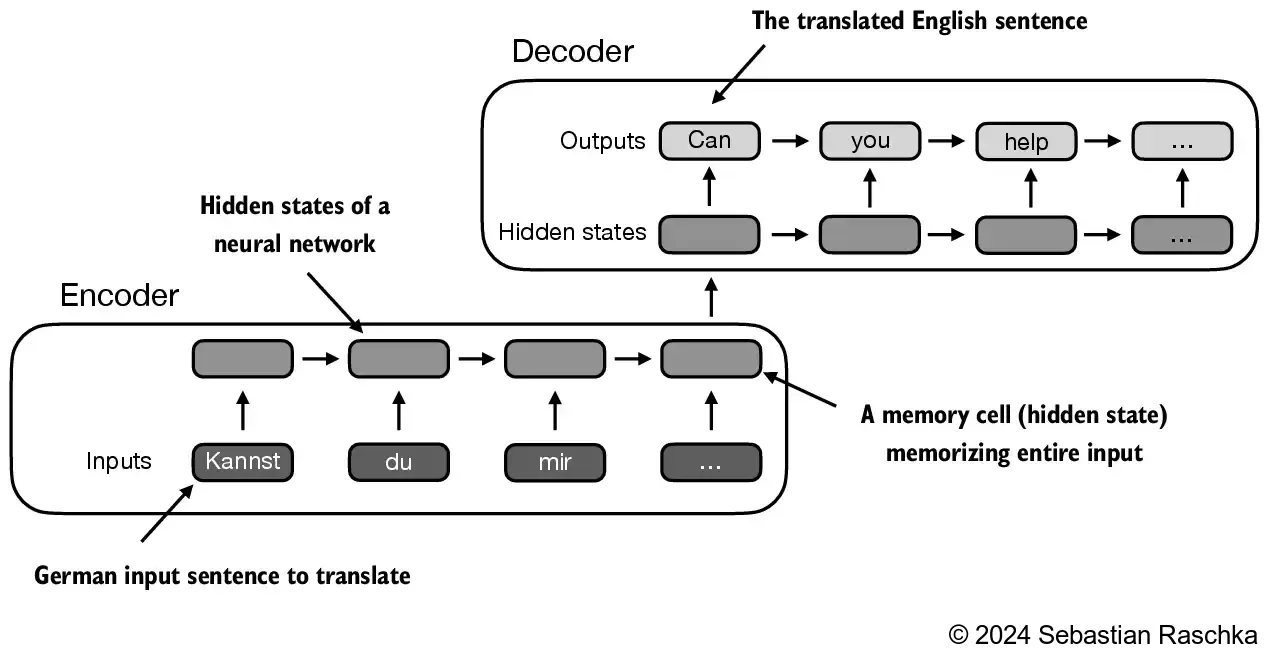
* 이 방식의 인코더는 토큰을 입력 받아서 전체 입력 토큰의 모든 정보를 한 곳에 담은 표현을 은닉층에 저장했다.
* 이렇게 되면 멀리 떨어져 있는 단어의 토큰 정보가 점점 희석 되면서 해당 은닉층이 전체 문장의 맥락을 효과적으로 저장할 수 없다는 가장 큰 한계점이 있다. 

### 어텐션 매커니즘을 사용해서 데이터 종속성을 고려하기
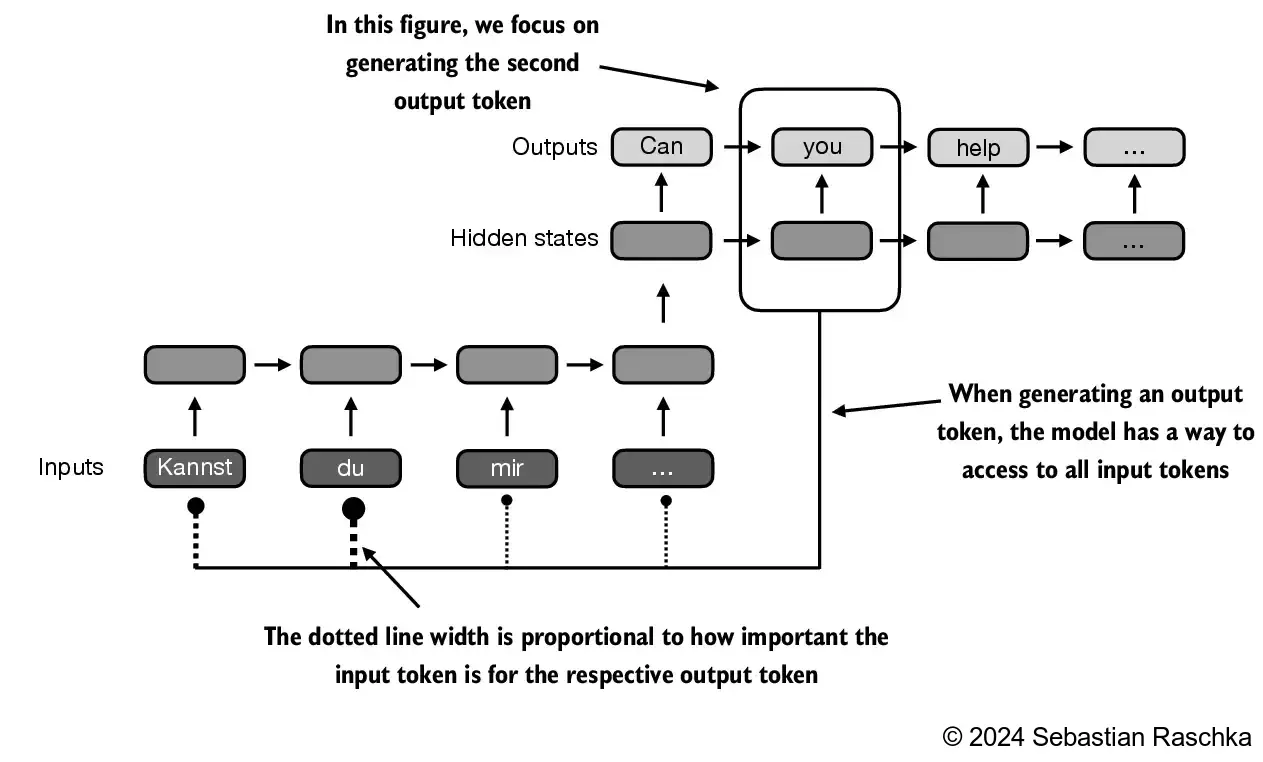
어텐션 매커니즘을 사용해서 텍스트를 생성하는 디코더는 모든 입력 토큰들을 모두 고려할 수 있게 됐으며, 특히 입력 토큰중에서 더 자세히 보아야 할 부분을 판단할 수 있게 됐다.
* 즉 특정 토큰을 생성할 때 이제는 수많은 입력 토큰 중에서 특별히 중요한 입력 토큰의 정보를 우선적으로 고려할 수 있게 됐다.


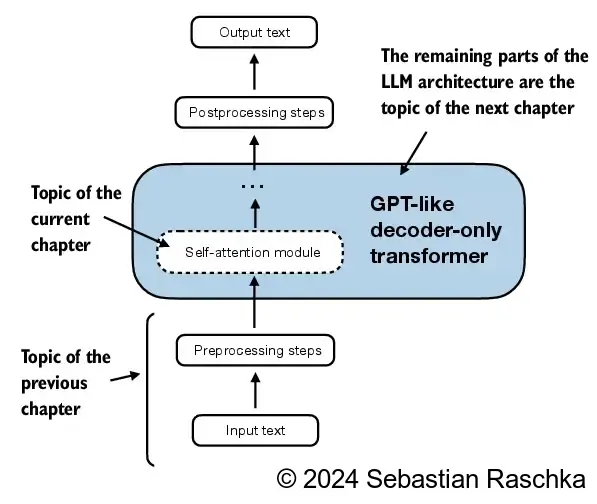
트랜스포머에서 self-attention은 시퀀스 내의 각 위치가 다른 모든 위치와 상호작용하며, 그 중요도를 판단할 수 있도록 하여 입력 표현을 향상시키기 위해 고안된 기법.

### self attention을 통해서 입력의 다른 부분에 집중하기
#### 학습 가능한 가중치를 제외한 단순한 self-attention 매커니즘 구현하기
이번에는 매우 단순한 self-attention을 구현할 것이고, 이 구현체는 가중치를 가지고 있지 않다.
* 이 코드는 단순히 이해를 돕기 위한 것이고 실제 트랜스포머에서 사용하는 구현체가 아니다
* 다음 챕터에서 단순한 어텐션 매커니즘을 실제 어텐션 매커니즘으로 구현한다.


입력 문장이 x(1) ~ x(T)으로 이루어져 있다고 가정하자. 각 x는 토큰의 임베딩 벡터 표현이다.

__우리의 목표는__  각 임베딩 벡터 x(i)에 해당하는 __문맥 벡터 z(i)__ 를 구하는 것이다.
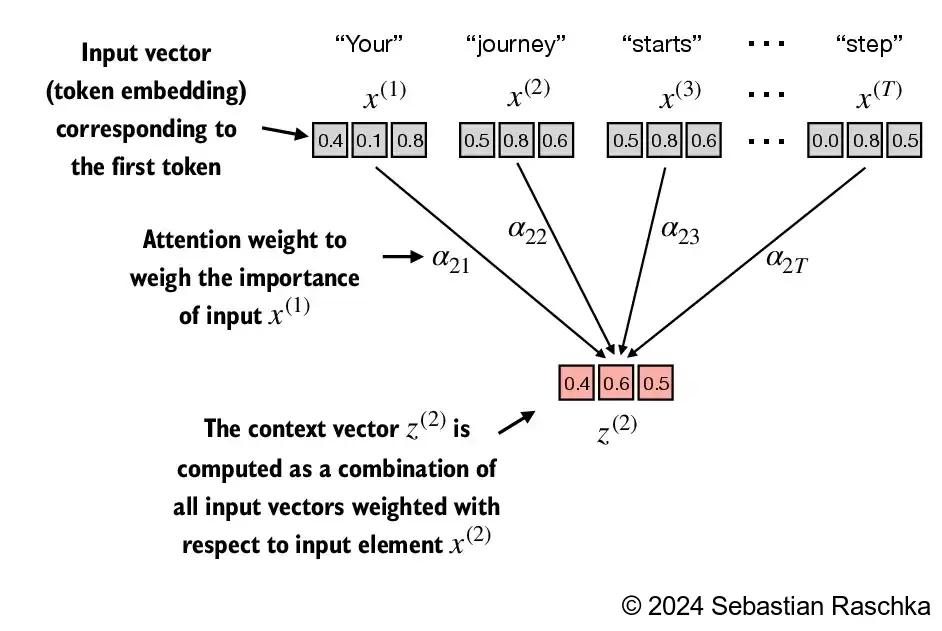
* 문맥 벡터 (context vector) z(i)는 x(1) 부터 x(T) 까지 벡터의 가중합이다.

예를 들어서 z(2)는 두번째 입력 벡터인 x(2)에 대해서 x(1) 부터 x(T)까지 모든 벡터에 특정한 가중치를 곱하고 모두 더한 것을 의미한다.
* 어텐션 가중치는 각 입력 요소가 z(2)를 계산할 때 얼마나 기여하는지 결정하는 값
* 다시말해서 z(2)는 x(2)와 관련된 모든 입력 요소들의 정보를 포함한 수정 버전이다.


관례적으로 어텐션 점수(attention score)를 정규화한 값을 어텐션 가중치 (attention weight)라고 한다.

##### 코드 구현
__step 1__ 정규화되지 않은 어텐션 점수 w 를 계산

두번째 입력 토큰을 쿼리라고 가정하자 즉 q(2) = x(2)라고 가정. 그러면 정규화되지 않은 attention score을 다음과 같이 내적을 통해 계산할 수 있다.  

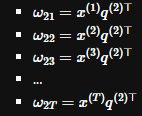  

여기서 아래첨자 _21_ 은 두번째 입력 쿼리와 첫번째 입력 토큰 사이 내적을 했다는 뜻이다.

* 참고로 입력 문장은 이미 3차원 벡터로 임베딩이 되어있다고 가정

In [2]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

/home/sangylee/.pyenv/versions/3.12.8/envs/llm-implement/lib/python3.12/site-packages/torch/_subclasses/functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


이 책에서는 일반적인 딥러닝 표현을 따른다.
* 행은 학습 데이터, 열은 특성 값
* 위 텐서의 경우 각 행은 단어를 나타내고 각 열은 임베딩 차원을 의미


첫번째 목표는 어떻게 문맥 벡터 (context vector) z(2)를 계산하는지 알아보는 것이기 때문에, 두번째 입력 토큰인 x(2)를 쿼리로 설정한다.

아래 그림은 어텐션 점수를 계산하는 첫번째 과정을 보여준다. 쿼리 임베딩 벡터는 나머지 모든 임베딩 벡터에 대해서 내적을 계산한다. (자기 자신도 계산한다) 

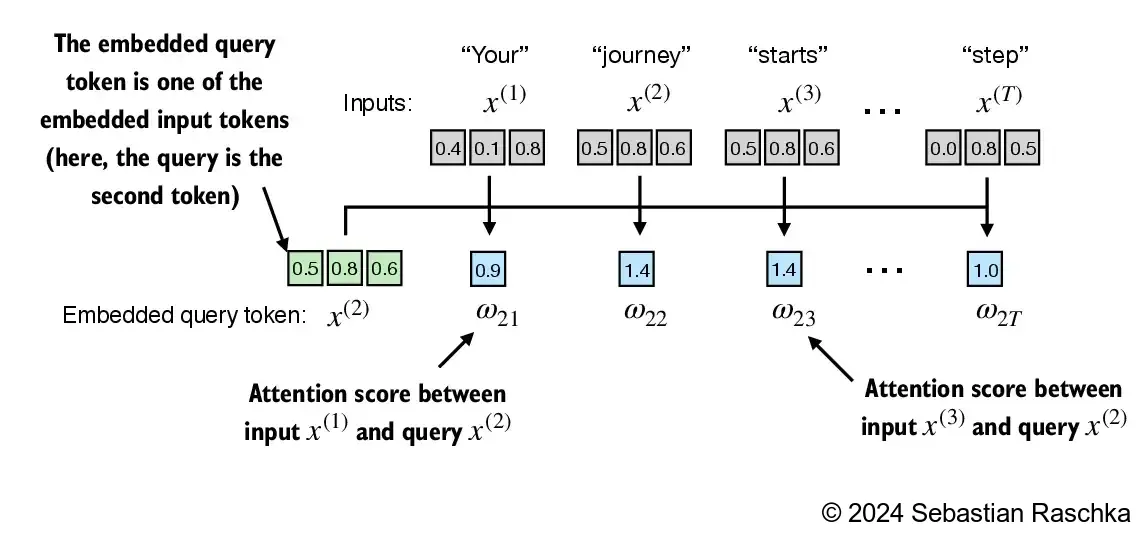 

* 여기서는 2번째 토큰인 x(2)에 대해서만 계산하지만 이후에는 __모든 문맥 벡터를 계산하게__ 행렬곱으로 일반화한다.
* 첫번째 단계는 쿼리 벡터인 x(2)와 모든 입력 토큰 사이 내적을 계산해서 정규화되지 않은 어텐션 값 (attention score)을 계산하는 것이다.

In [4]:
query = inputs[1] #2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    # 둘다 1차원 벡터이기 때문에 전치가 필요 없다.
    attn_scores_2[i] = torch.dot(query, x_i)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


__step 2__ : 정규화 되지 않은 어텐션 점수값을 정규화 한다.
* 정규화는 모든 값을 더했을때 1이 되게 만드는 것.

가장 간단한 방법은 어텐션 점수의 총 합으로 각 점수를 나누면 된다.
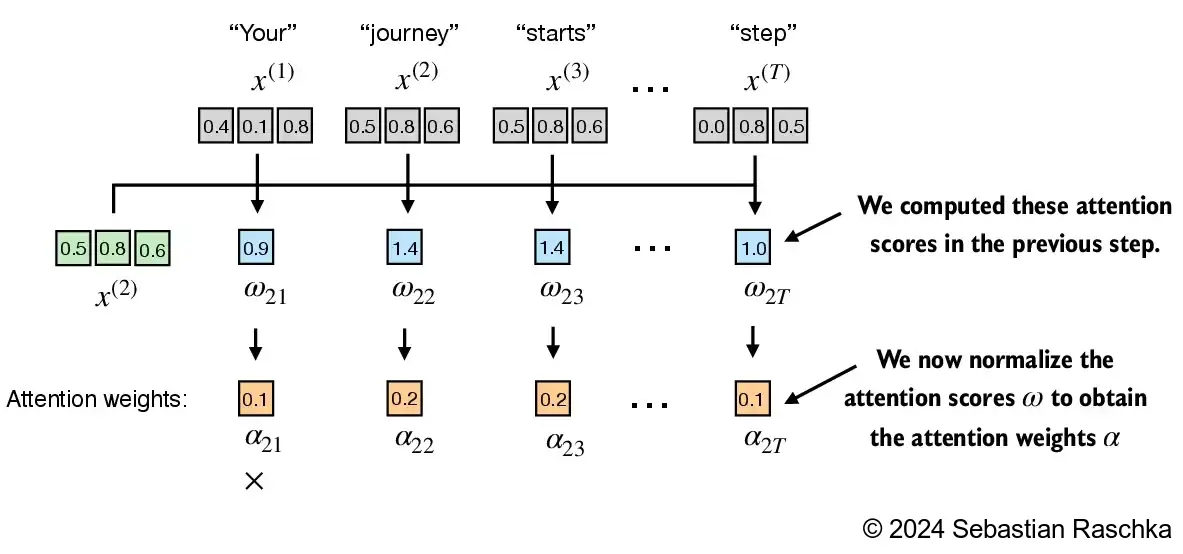

In [7]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


__하지만__

실제로는 정규화를 할 때 _softmax 함수_ 를 사용한다.
* 이 함수는 극단적인 수치를 다루기 더 좋으며, 학습할때 더 바람직한 기울기 속성을 가지고 있기 때문.
* 다음 함수는 스케일링을 위한 소프트맥스 함수의 단순한 구현이며, 이 방식 또한 벡터의 요소를 총 합 1인 상태로 정규화한다. 

In [9]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


위에 있는 단순한 구현은 오버플로우나 언더플로우 문제 때문에 매우 큰 숫자나 작은 숫자 입력값에 대해서 수치적 안정성 문제가 발생한다.
* 그래서 실제로는 파이토치에서 구현한 softmax 함수를 사용하는게 좋다.

In [12]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


__step 3__: 임베딩된 입력 토큰에 어텐션 가중치를 곱하고 모두 더해서 문맥 벡터 z(2)를 구한다.
* x(i)에 어텐션 가중치를 곱하고 모두 더하면 결과값이 나옴
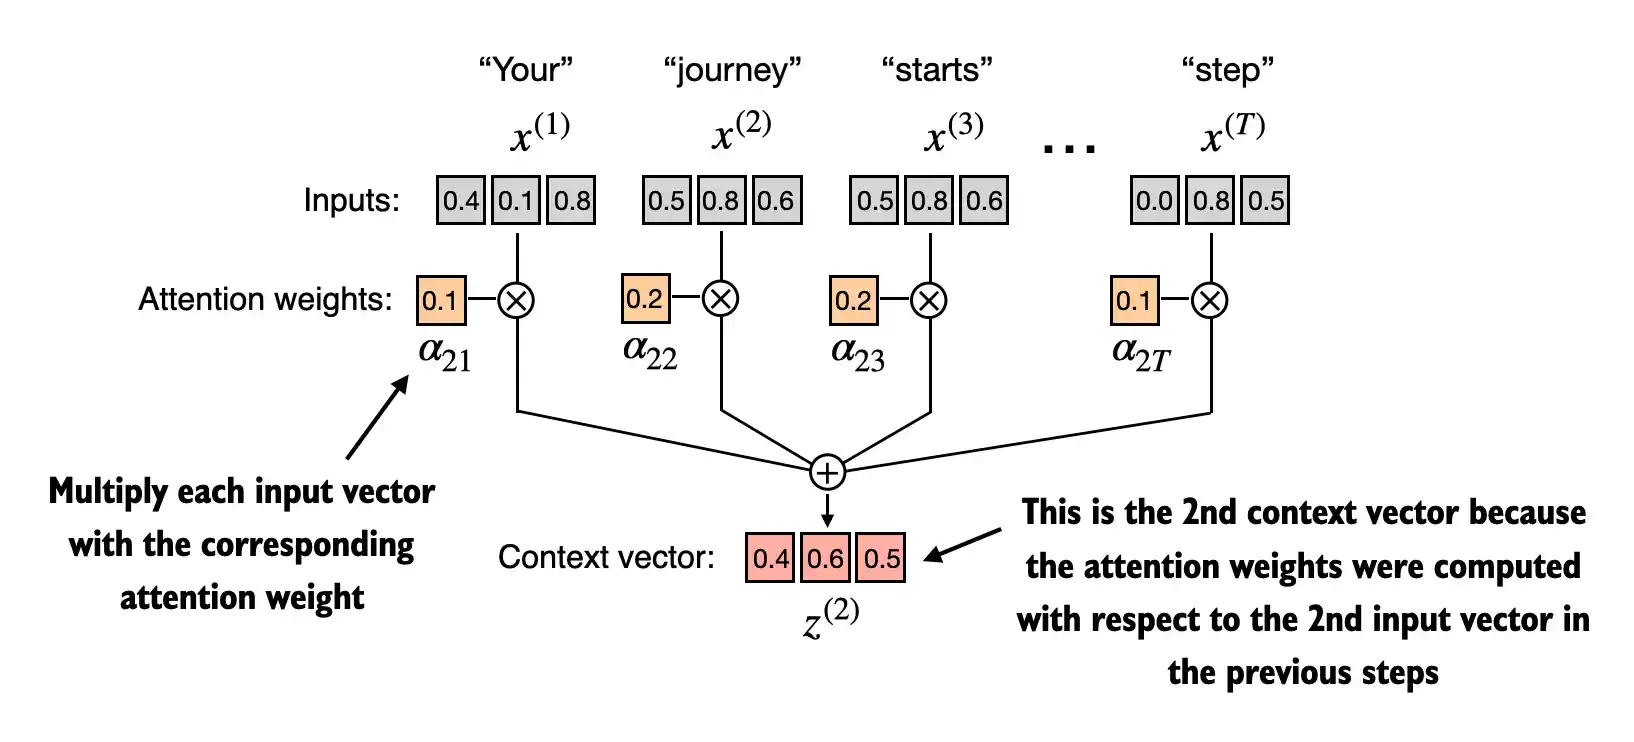

In [13]:
query = inputs[1]

context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


#### 모든 입력 토큰에 대해서 어텐션 가중치 (attention weights) 를 구하기

__모든 입력 토큰을 대상으로 일반화하기__
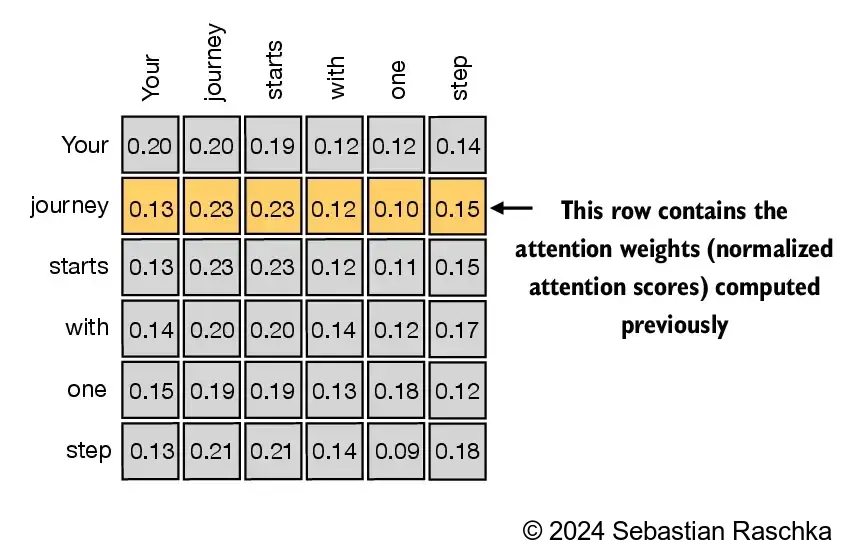
* 지금까지는 토큰 2에 대해서 어텐션 가중치와 문맥 벡터를 구했다면 이제는 모든 토큰에 대해서 어텐션 가중치와 문맥 벡터를 


self-attention에서 어텐션 점수를 구하는 것부터 출발한다. 그 이후에는 어텐션 점수를 정규화해서 어텐션 가중치를 구한다.
* 이 어텐션 가중치는 입력 벡터에 가중합을 구해서 문맥 벡터를 생성한다.
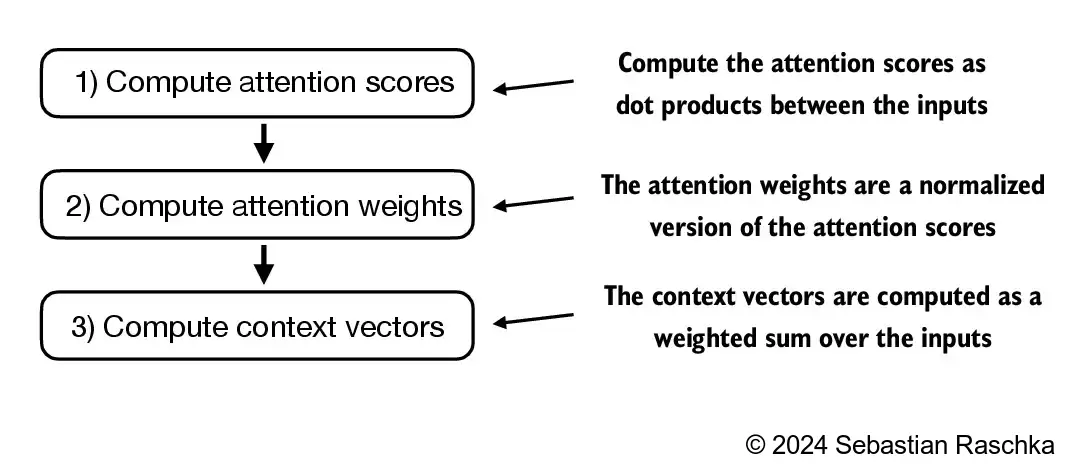

In [21]:
# step1 - 입력 토큰 행렬끼리 곱하면 쉽게 각 토큰끼리 유사도를 구할 수 있다. (정규화 x)
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


__항상 헷갈리는 축의 개념__ 

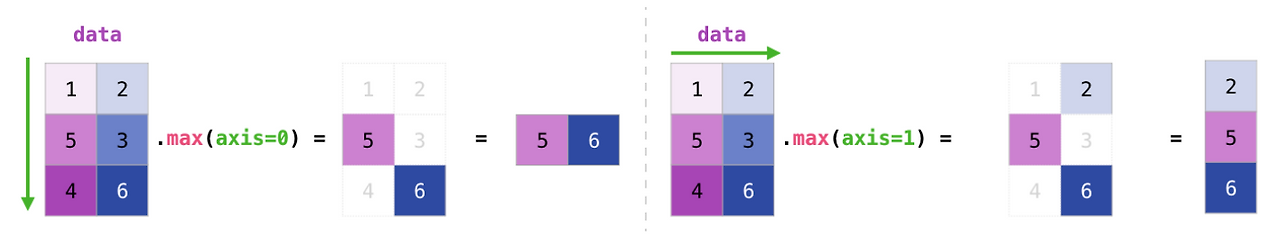

0 -> 행으로 계산, 1 -> 열으로 계산

In [22]:
# step2 - 각 행을 상대로 정규화를 진행
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [23]:
# step3 - 어텐션 가중치에 입력 임베딩 토큰 행렬을 곱한다.
# (5, 5) * (5, 3) 
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [24]:
# 위에서 2번째 토큰 대상으로 구한 값이랑 비교
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


### 학습 가능한 가중치를 포함한 self attention 구현하기


https://github.com/rasbt/LLMs-from-scratch/tree/main/ch03/01_main-chapter-code